In [ ]:
## ############################################################################
## CODE: Density of Bar models: Sormani+22, Long&Murali+92,
## AUTHOR: MATIAS A. BLANA D.
## CHILE, APRIL 2023
## ############################################################################

In [57]:
import sys
import os
import time
import emcee
import corner
import numpy as np
from decimal import Decimal
from matplotlib import rc
from astropy import units as u
# import astropy.coordinates as coord
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from astropy.cosmology import Planck15, z_at_value
# rc('text', usetex=True)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
# sys.path.append('../DYNO')
# %run ../DYNO/DYNO_FUN_v1.0.ipynb

In [24]:
#################################################3
## help functions
def f_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

def reshape2to1(datafield):
    nx, ny = datafield.shape
    datafield1D = datafield.copy()
    n1D = nx*ny
    datafield1D.resize((n1D, 1))
    return datafield1D

def reshape1to2(datafield,nx,ny):
    datafieldout = datafield.copy()
    datafieldout.resize((nx,ny))
    return datafieldout

def reshape3to1(datafield):
    nx, ny ,nz = datafield.shape
    datafield1D = datafield.copy()
    n1D = nx*ny*nz
    datafield1D.resize((n1D, 1))
    return datafield1D

def reshape1to3(datafield,nx,ny,nz):
    datafieldout = datafield.copy()
    datafieldout.resize((nx,ny,nz))
    return datafieldout


In [25]:
#################################################################
def MWbarS22(vec): # MW Bar(+inner disk) model from Sormani+2022
    #Param: Bar1
    rho1,x1,y1,z1,cll,cT,m,al,n,c,xc,yc,rcut = 0.316E10,0.490,0.392,0.229,1.991,2.232,0.873,0.626,1.940,1.342,0.751,0.469,4.370 # Msun/kpc3, .. kpc ...
    par1 = [rho1,x1,y1,z1,cll,cT,m,al,n,c,xc,yc,rcut]
    
    #Param: Disc
    Sig0,Rd,zd,Rcut,nd,md = 0.103E10,4.754,0.151,4.688,1.536,0.716 # Msun/kpc3, .. kpc ...
    parD = [Sig0,Rd,zd,Rcut,nd,md]
    
    #Param: Bar2
    rho2,x2,y2,z2,n2,cT2,Rout2,Rin2,nout2,nin2 = 0.05E10,5.364,0.959,0.611,3.051,0.970,3.190,0.558,16.731,3.196 # Msun/kpc3, .. kpc ...
    par2 = [rho2,x2,y2,z2,n2,cT2,Rout2,Rin2,nout2,nin2]
    
    #Param: Bar3
    rho3,x3,y3,z3,n3,cT3,Rout3,Rin3,nout3,nin3 = 1743.049E10,0.478,0.267,0.252,0.980,1.879,2.204,7.607,-27.291,1.630 # Msun/kpc3, .. kpc ...
    par3 = [rho3,x3,y3,z3,n3,cT3,Rout3,Rin3,nout3,nin3]
    
    rho = rhobar1(vec,par1)+rhobar23(vec,par2)+rhobar23(vec,par3)+rhodisc(vec,parD)
    # rho = rhodisc(vec,parD) 
    # rho = rhobar1(vec,par1)
    return rho

def rhobar1(vec,pari):
    rhoi,xi,yi,zi,clli,cTi,mi,ali,ni,ci,xci,yci,rcuti = pari
    ix,iy,iz = vec
    Ri       = (ix**2 + iy**2)**0.5
    ri       = (ix**2 + iy**2 + iz**2)**0.5    
    ai       = ( ((abs(ix)/xi)**cTi + (abs(iy)/yi)**cTi)**(clli/cTi) + (abs(iz)/zi)**clli )**(1./clli)
    aip      = ( ((ix+ci*iz)/xci)**2. + (iy/yci)**2. )**0.5
    ain      = ( ((ix-ci*iz)/xci)**2. + (iy/yci)**2. )**0.5
    secham   = 1./np.cosh(ai**mi)
    rhobar1  = rhoi * secham * (1. + ali*(np.e**(-aip**(ni)) + np.e**(-ain**ni)))**(-(ri/rcuti)**2)
    return rhobar1

def rhobar23(vec,pari):
    rhoi,xi,yi,zi,ni,cTi,Routi,Rini,nouti,nini = pari
    ix,iy,iz = vec
    ai       = ((abs(ix)/xi)**cTi + (abs(iy)/yi)**cTi)**(1./cTi)
    Ri       = (ix**2 + iy**2)**0.5
    sech2zi  = (1./np.cosh(iz/zi))**2
    rhobari  = rhoi* np.e**(-ai**ni) * sech2zi * np.e**(-(Ri/Routi)**nouti) * np.e**(-(Rini/Ri)**nini)
    return rhobari

def rhodisc(vec,pari):
    Sig0i,Rdi,zdi,Rcuti,ndi,mdi = pari
    ix,iy,iz = vec    
    Ri       = (ix**2 + iy**2)**0.5
    sechmdzi = (1./np.cosh((abs(iz)/zdi)**mdi))    
    rhodisci = Sig0i/4./zdi * np.e**(-(Ri/Rdi)**ndi) * np.e**(-Rcuti/Ri) * sechmdzi
    # rhodisci = Sig0i/4./zdi * np.e**(-(Ri/Rdi)**ndi) * np.e**(-Rcuti/Ri)
    return rhodisci

In [26]:
def barLM92(vec,M=1.E10,a=2.0,b=1.0,c=0.1): # Bar Model from Long & Murali 1992 ApJ,397,44 
    # Define constants
    # a = 2.0  # Example value
    # b = 1.0  # Example value
    # c = 0.1  # Example value
    # G = 6.67430e-11  # Gravitational constant
    # G = G_kpcMsunkpc2Myr2
    # M = 5.972e24  # Earth mass
    # M     = 1E10 # Msun
    # GM    = G*M
    x,y,z = vec

    # Define expressions for Tp and Tm
    cz      = (c**2+z**2)**0.5
    bz      = b + cz
    fyz     = y**2 + bz**2
    dfyzdz  = 2.*bz*z/cz
    Tp      = ((a + x)**2 + fyz)**0.5
    Tm      = ((a - x)**2 + fyz)**0.5
    F4x     = 4.*x**2/(Tp+Tm)
    F4xT2   = 4.*x**2/(Tp+Tm)**2

    gradxixG = 2.*M/(Tp*Tm*(Tp+Tm)) 
    gradyiyG = M/(2.*Tp*Tm*fyz)*(Tp+Tm-F4x)
    gradzizG = M/(2.*Tp*Tm*fyz)*(Tp+Tm-F4x)*(bz/cz)
    
    dT2pdx = 2.*(a+x)
    dT2mdx = 2.*(a-x)*(-1.)
    dT2pdy = 2.*y
    dT2mdy = 2.*y
    dT2pdz = 2.*bz*z/cz
    dT2mdz = 2.*bz*z/cz
    
    dTpdx = 0.5/Tp*dT2pdx
    dTmdx = 0.5/Tm*dT2mdx
    dTpdy = 0.5/Tp*dT2pdy
    dTmdy = 0.5/Tm*dT2mdy
    dTpdz = 0.5/Tp*dT2pdz
    dTmdz = 0.5/Tm*dT2mdz
    
    # grad2_xx
    laplacian_xiG = -2.*M/(Tp*Tm*(Tp+Tm))**2*x*(Tp**2*dTmdx + Tm**2*dTpdx + 2.*Tp*Tm*(dTpdx+dTmdx)) + gradxixG
    
    # grad2_yy
    afac          = Tp + Tm - F4x
    bfac          = -1./(Tp*Tm*fyz**2)*y + 1./2./fyz*(-1./(Tp*Tm**2)*dTmdy - 1./(Tm*Tp**2)*dTpdy)
    cfac          = 1./(2*Tp*Tm*fyz)
    dfac          = (dTpdy + dTmdy)*(1.+ F4xT2) 
    laplacian_yiG = M*y*(afac *bfac + cfac*dfac) + gradyiyG
    
    # grad2_zz
    efac          = (Tp + Tm - F4x) * (z/cz**2 - bz*z/cz**3) +  bz/cz*(dTpdz+dTmdz)*(1.+F4xT2)
    ffac          = -1./(Tp*Tm*fyz**2)*dfyzdz - 1./(fyz*Tp**2*Tm**2)*(Tp*dTmdz + Tm*dTpdz)
    laplacian_ziG = M/2.*z* ( 1./(Tp*Tm*fyz)*efac + (Tp + Tm - F4x)*bz/cz * ffac ) + gradzizG

    # Calculate Laplacian
    laplacian_F   = laplacian_xiG + laplacian_yiG + laplacian_ziG    
    rho           = laplacian_F/np.pi/4.

    return rho

# Print the Laplacian
# print(laplacian_phi)


In [27]:
def rhoMND(vec,M=1.0E10,a=2.0,b=1.0):
    x,y,z = vec
    R2    = x**2 + y**2
    b2    = b**2
    bz    = (z**2+b2)**0.5
    A     = a*R2 + (3.*bz+ a)*(bz+a)**2
    B     = (R2 + (bz+a)**2)**2.5 * bz**3
    rho   = b2*M/(4.*np.pi) * A / B 
    return rho

def rhoPlum(vec,M=1.0E10,a=1.):
    x,y,z = vec
    r     = (x**2+y**2+z**2)**0.5
    rho   = 3./(4.*np.pi)*M/(a**3)* 1./(1. + (r/a)**2)**2.5
    return rho

In [28]:
############################################################
### Composite models to fit the Sormani+22 model. 
def rhoMWmod_v2c(vec,params):
    Mbar1,abar1,bbar1,cbar1,Mdisk1,adisk1,bdisk1 = params
    rho = barLM92(vec,Mbar1,abar1,bbar1,cbar1) + rhoMND(vec,Mdisk1,adisk1,bdisk1) 
    return rho/1E9

def rhoMWmod_v3c(vec,params):
    Mbar1,abar1,bbar1,cbar1,Mbar2,abar2,bbar2,cbar2,Mdisk1,adisk1,bdisk1=params
    rho = barLM92(vec,Mbar1,abar1,bbar1,cbar1) + barLM92(vec,Mbar2,abar2,bbar2,cbar2) + \
          rhoMND(vec,Mdisk1,adisk1,bdisk1)
    return rho

def rhoMWmod_v4c(vec,params):
    Mbar1,abar1,bbar1,cbar1,Mbar2,abar2,bbar2,cbar2,Mdisk1,adisk1,bdisk1,Mplum1,aPlum1 = params
    rho = barLM92(vec,Mbar1,abar1,bbar1,cbar1) + barLM92(vec,Mbar2,abar2,bbar2,cbar2) + \
          rhoMND(vec,Mdisk1,adisk1,bdisk1) + rhoPlum(vec,Mplum1,aPlum1)
    return rho

def rhoMWmod_v5c(vec,params):
    Mbar1,abar1,bbar1,cbar1,Mbar2,abar2,bbar2,cbar2,Mdisk1,adisk1,bdisk1,Mdisk2,adisk2,bdisk2,Mplum1,aPlum1 =params
    rho    = barLM92(vec,Mbar1,abar1,bbar1,cbar1) + barLM92(vec,Mbar2,abar2,bbar2,cbar2) + \
             rhoMND(vec,Mdisk1,adisk1,bdisk1) + rhoMND(vec,Mdisk2,adisk2,bdisk2) +\
             rhoPlum(vec,Mplum1,aPlum1)
    return rho

In [118]:
#################################################
### creating grid x,y,z to calculate 3D densities
xcm,ycm,zcm      = 0.,0.,0.
LXlim,LYlim,LZlim = 10.,10., 1.0 #  
# LXlim,LYlim,LZlim = 10.,10., 1.0 #  
DD               = 0.1 # kpc
# DD               = 10. # kpc

DX,DY,DZ         = DD,DD,DD
Xlim,Ylim,Zlim   = LXlim/2,LYlim/2,LZlim/2
xg_1D            = np.hstack((-np.arange(DX,Xlim+DX,DX)[::-1], np.arange(0,Xlim+DX,DX))) + xcm
yg_1D            = np.hstack((-np.arange(DY,Ylim+DY,DY)[::-1], np.arange(0,Ylim+DY,DY))) + ycm
zg_1D            = np.hstack((-np.arange(DZ,Zlim+DZ,DZ)[::-1], np.arange(0,Zlim+DZ,DZ))) + zcm
izcenter         = len(zg_1D)-len(np.arange(DZ,Zlim+DZ,DZ)[::-1]) - 1
# zg_1D            = np.zeros((1))
nX               = len(xg_1D)
nY               = len(yg_1D)
nZ               = len(zg_1D)
ngtot            = nX*nY*nZ
LXlim            = np.amax(xg_1D)-np.amin(xg_1D)
LYlim            = np.amax(yg_1D)-np.amin(yg_1D)
LZlim            = np.amax(zg_1D)-np.amin(zg_1D)
Xg_2D,Yg_2D,Zg_2D= np.meshgrid(xg_1D,yg_1D,zg_1D)
# Xg_3D,Yg_3D,Zg_3D = np.meshgrid(xg_1D,yg_1D,zg_1D)
Yg_1D            = reshape3to1(Yg_2D)
Xg_1D            = reshape3to1(Xg_2D)
Zg_1D            = reshape3to1(Zg_2D)
vec_data         = np.array([np.squeeze(Xg_1D),np.squeeze(Yg_1D),np.squeeze(Zg_1D)])
print(f'nX,nY,nZ={nX,nY,nZ}')
print(f'nX*nY*nZ={nX*nY*nZ} = {f_e(nX*nY*nZ)}')

nX,nY,nZ=(101, 101, 11)
nX*nY*nZ=112211 = 1.12211E+05


In [119]:
####################################################
#### Calculating densities in the grid, S22 to be fitted, and Long&Murali as example
rho_1D_data  = MWbarS22(vec_data)
rho_2D_data  = reshape1to3(rho_1D_data,nX, nY, nZ)
print(f'rho_max S22={f_e(np.amax(rho_1D_data))} M/kpc3')
print(f'rho_min S22={f_e(np.amin(rho_1D_data))} M/kpc3')

rho_max S22=3.16E+09 M/kpc3
rho_min S22=2.628841E+07 M/kpc3


/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in power
/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide


/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  from ipykernel import kernelapp as app
/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: The following kwargs were not used by contour: 'color', 'interpolation'
  app.launch_new_instance()


(-6.0, 6.0)

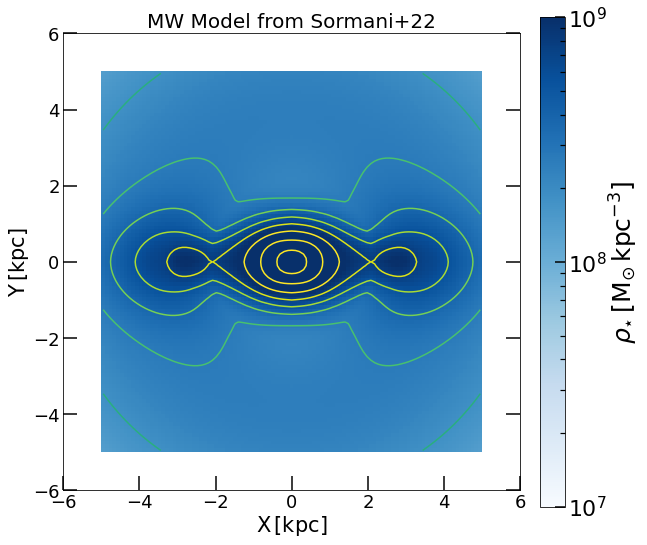

In [120]:
xedges = xg_1D
yedges = yg_1D
Lim    = 6.
fig    = plt.figure(figsize=(9, 9))
# figtest.subplots_adjust(hspace=0.45, wspace=0.3)
ax   = fig.add_subplot(1, 1, 1)
# vmax,vmin = np.log10(2E8),np.log10(2E4)
# vmax,vmin = np.log10(2E9/1E9),np.log10(2E5/1E9)
# vmax,vmin = np.log10(1E9),np.log10(1E6)
vmax,vmin = 1E9,1E7
levelslog = np.logspace(np.log10(vmin),np.log10(vmax)+1,20)
# cmap = plt.get_cmap("inferno")
colormap = plt.get_cmap("Blues")

CS   = ax.imshow(rho_2D_data[:,:,izcenter],cmap =colormap,norm=colors.LogNorm(),interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmax=vmax,vmin=vmin)
CS2   = ax.contour(rho_2D_data[:,:,izcenter], levels=levelslog, color='k',norm=colors.LogNorm(),interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmax=vmax,vmin=vmin)
# CS = ax.imshow(np.log10(abs(Hs)), interpolation='nearest', origin='lower')
cbar  = fig.colorbar(CS, ax=ax,fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=22, direction='in',which='major', length=10, width=1.5) 
cbar.ax.tick_params(labelsize=22, direction='in',which='minor', length=5, width=1.2) 
cbar.set_label(r'$\rho_{\star}\,[{\rm M_{\odot}\,kpc^{-3}}]$', rotation=90,fontsize=25,labelpad=1)


ax.set_xlabel(r"${\rm X}\,[{\rm kpc}]$", fontsize=21, labelpad=1.9)
ax.set_ylabel(r"${\rm Y}\,[{\rm kpc}]$", fontsize=21, labelpad=1.9)
ax.set_title(f'MW Model from Sormani+22',fontsize=20)
ax.tick_params(axis='x', labelsize=18, length=14, width=1.5, which='major', direction='in')
ax.tick_params(axis='y', labelsize=18, length=14, width=1.5, which='major', direction='in',right='True')
ax.tick_params(axis='x', labelsize=15, length=9, width=1, which='minor', direction='in')
ax.tick_params(axis='y', labelsize=15, length=9, width=1, which='minor', direction='in',right='True')
# figtest.savefig(outputfile+"_PlotNbody.pdf", bbox_inches='tight') # for Zixuan v3
ax.set_xlim((-Lim,Lim))
ax.set_ylim((-Lim,Lim))

/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'color', 'interpolation'


(-6.0, 6.0)

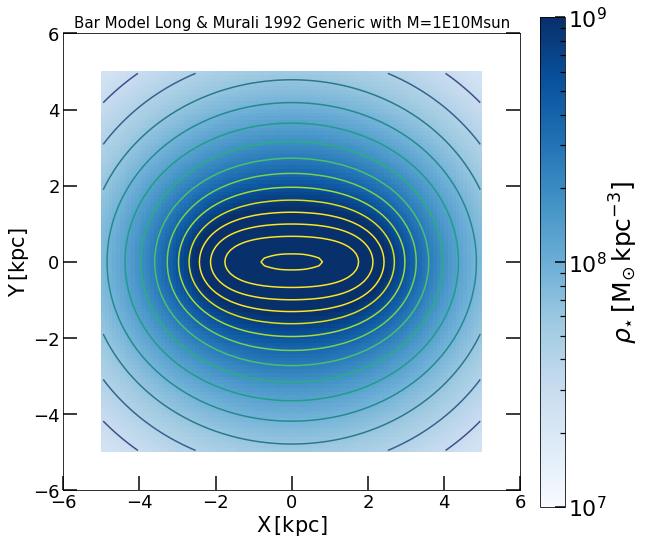

In [121]:
####################################################
### PLOTTING GENERIC LONG & MURALI 1992 MODEL
rho_1D_LM    = barLM92(vec_data)
rho_2D_LM    = reshape1to3(rho_1D_LM,nX, nY, nZ)

xedges = xg_1D
yedges = yg_1D
Lim    = 6.
fig    = plt.figure(figsize=(9, 9))
# figtest.subplots_adjust(hspace=0.45, wspace=0.3)
ax   = fig.add_subplot(1, 1, 1)
vmax,vmin = 1E9,1E7
levelslog = np.logspace(np.log10(vmin),np.log10(vmax)+1,20)
# cmap = plt.get_cmap("inferno")
colormap = plt.get_cmap("Blues")

CS   = ax.imshow(rho_2D_LM[:,:,izcenter],cmap =colormap,norm=colors.LogNorm(),interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmax=vmax,vmin=vmin)
CS2   = ax.contour(rho_2D_LM[:,:,izcenter], levels=levelslog, color='k',norm=colors.LogNorm(),interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmax=vmax,vmin=vmin)
cbar  = fig.colorbar(CS, ax=ax,fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=22, direction='in',which='major', length=10, width=1.5) 
cbar.ax.tick_params(labelsize=22, direction='in',which='minor', length=5, width=1.2) 
cbar.set_label(r'$\rho_{\star}\,[{\rm M_{\odot}\,kpc^{-3}}]$', rotation=90,fontsize=25,labelpad=1)

ax.set_xlabel(r"${\rm X}\,[{\rm kpc}]$", fontsize=21, labelpad=1.9)
ax.set_ylabel(r"${\rm Y}\,[{\rm kpc}]$", fontsize=21, labelpad=1.9)
ax.set_title(f'Bar Model Long & Murali 1992 Generic with M=1E10Msun',fontsize=15)
ax.tick_params(axis='x', labelsize=18, length=14, width=1.5, which='major', direction='in')
ax.tick_params(axis='y', labelsize=18, length=14, width=1.5, which='major', direction='in',right='True')
ax.tick_params(axis='x', labelsize=15, length=9, width=1, which='minor', direction='in')
ax.tick_params(axis='y', labelsize=15, length=9, width=1, which='minor', direction='in',right='True')
# figtest.savefig(outputfile+"_PlotNbody.pdf", bbox_inches='tight') # for Zixuan v3
ax.set_xlim((-Lim,Lim))
ax.set_ylim((-Lim,Lim))

In [122]:
#################################################
### FITTING SORMANI DENSITY WITH EMCEE TO MODELS
# Define the log-likelihood function
def log_likelihood(params, x, y, yerr):
    model = modelf(x, params)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

# Define the prior for parameters (you can define your priors here)
def log_prior(params):
    # Example: Uniform priors for parameters
    if all(0.0 < p for p in params):
        return 0.0
    return -np.inf

# Define the log-posterior function
def log_posterior(params, x, y, yerr):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, x, y, yerr)

def modelf(x, params):
    # Modify this function to match your model
    # rho = rhoMWmod_v5c(x,params)
    # rho = rhoMWmod_v4c(x,params)
    rho = rhoMWmod_v3c(x,params)
    return rho


100%|██████████| 1000/1000 [29:09<00:00,  1.75s/it]
/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


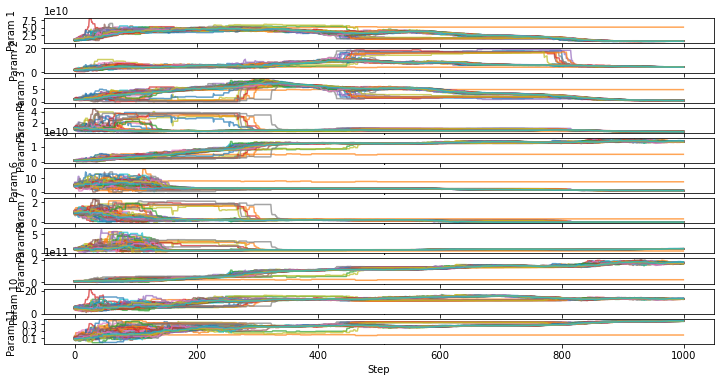

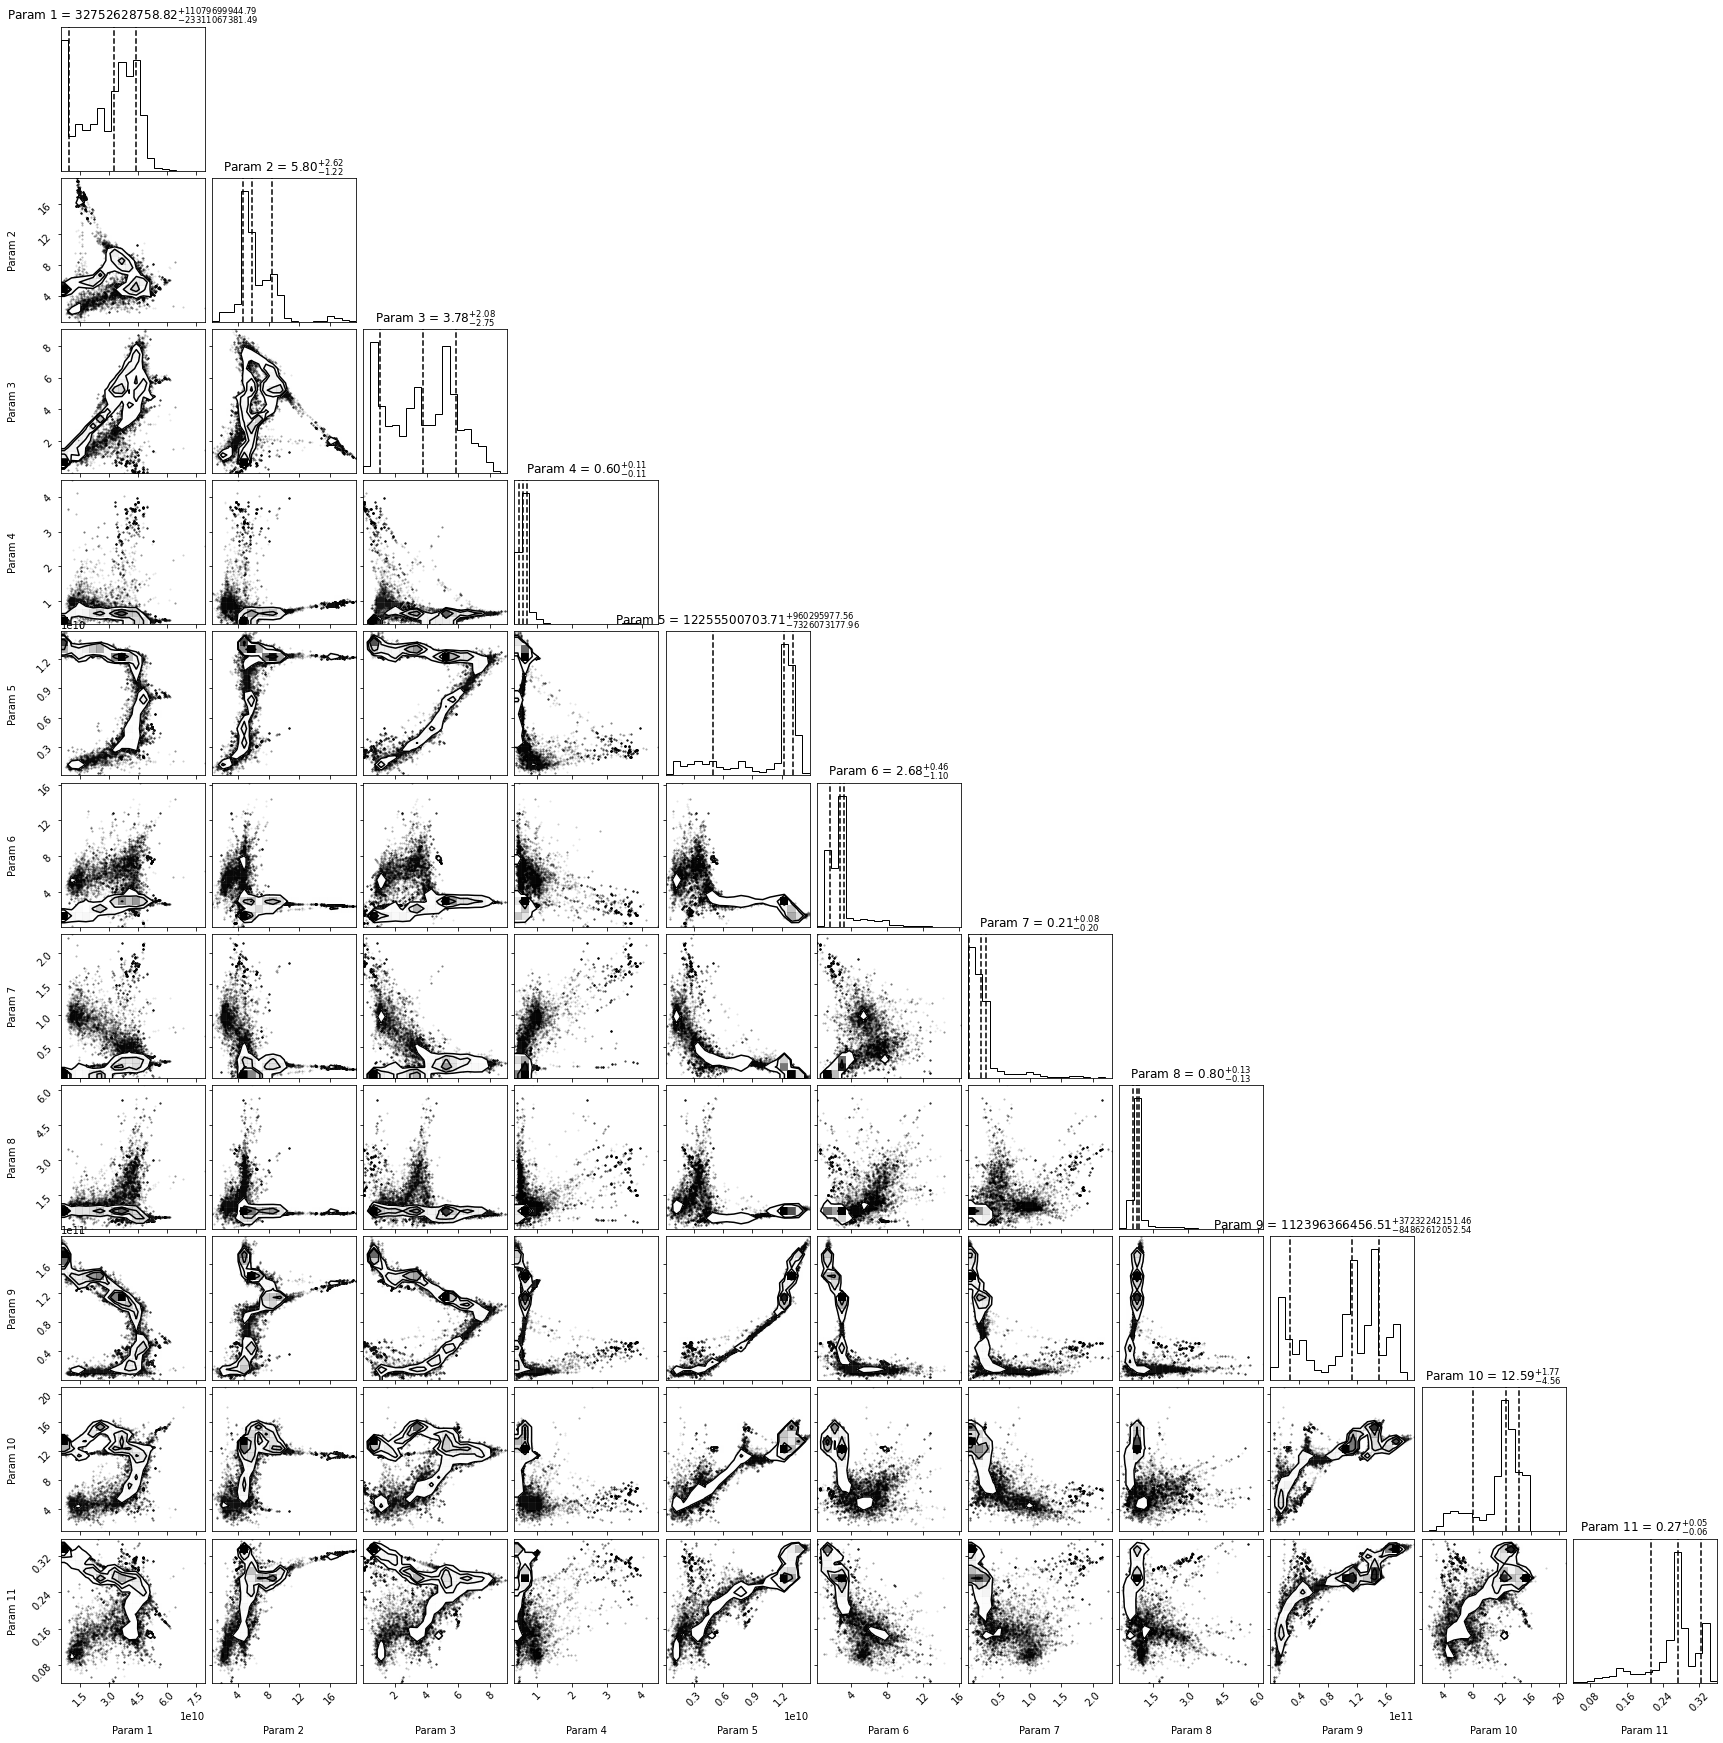

In [123]:
################################################################################
# Sample data TO FIT Sormani+22 "data", assuming 10% error
x_data,y_data, yerr = vec_data.astype(np.float64), rho_1D_data.astype(np.float64), (rho_1D_data.astype(np.float64))*0.1

iMbar1,iabar1,ibbar1,icbar1= 1E10, 2, 1, 1
iMbar2,iabar2,ibbar2,icbar2= 1E9, 5, 1, 1
iMdisk1,iadisk1,ibdisk1= 1E10, 5, 0.1
iMdisk2,iadisk2,ibdisk2= 1E9, 1, 0.1
iMplum1,iaPlum1= 1E10,0.5

# Initial parameter guess and standard deviations
initial_guess = np.array([iMbar1,iabar1,ibbar1,icbar1,iMbar2,iabar2,ibbar2,icbar2,iMdisk1,iadisk1,ibdisk1])
# initial_guess = np.array([iMbar1,iabar1,ibbar1,icbar1,iMbar2,iabar2,ibbar2,icbar2,iMdisk1,iadisk1,ibdisk1,iMplum1,iaPlum1])
# initial_guess = np.array([iMbar1,iabar1,ibbar1,icbar1,iMbar2,iabar2,ibbar2,icbar2,iMdisk1,iadisk1,ibdisk1,iMdisk2,iadisk2,ibdisk2,iMplum1,iaPlum1])

num_params    = len(initial_guess)
param_stddev  = initial_guess.copy()

# Set up the emcee sampler
# Create the EnsembleSampler with the desired number of threads (CPUs)
threads = 10  # Set this to the number of CPUs you want to use

nwalkers = 100
ndim     = len(initial_guess)
nsteps   = 1000
sampler  = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,threads=threads, args=(x_data, y_data, yerr))
time_start= time.time()
# Initialize the walkers
initial_pos = [initial_guess + np.random.randn(ndim)*0.1 * param_stddev for _ in range(nwalkers)]

# Run the MCMC sampler
sampler.run_mcmc(initial_pos, nsteps, progress=True)

time_end = time.time() - time_start
os.system(f'say "Calculations finished after {round(time_end/60.,1)} minutes"')

# Get the chain of samples
chain = sampler.chain

# Plot trace plots for each parameter
plt.figure(figsize=(12, 6))

for i in range(ndim):
    plt.subplot(ndim, 1, i + 1)
    for walker in range(nwalkers):
        plt.plot(chain[walker, :, i], alpha=0.7)
    plt.ylabel(f'Param {i + 1}')
    plt.xlabel('Step')

plt.tight_layout()
plt.show()

# Get the samples
samples = sampler.chain[:, :, :].reshape((-1, ndim))

# # Plot the results
# fig, axes = plt.subplots(num_params, figsize=(10, 7), sharex=True)
samples = sampler.chain[:, :, :].reshape((-1, ndim))
labels = [f"Param {i+1}" for i in range(num_params)]

# Plot a corner plot
figure = corner.corner(samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})

plt.show()


In [124]:
best_fit_params = samples[np.argmax(sampler.flatlnprobability)]
print("Best-Fitting Parameters:", best_fit_params)

Best-Fitting Parameters: [6.55401847e+09 5.03455449e+00 8.10282102e-01 4.71257653e-01
 1.38178114e+10 1.36365827e+00 1.88559981e-02 8.81905876e-01
 1.73667379e+11 1.33997087e+01 3.33768265e-01]


In [125]:
# Calculate the median of each parameter from the samples
parameter_medians = np.median(sampler.chain, axis=(0, 1))
print("Best-Fitting Parameter Medians:", parameter_medians)

Best-Fitting Parameter Medians: [3.27526288e+10 5.80202380e+00 3.78303633e+00 5.95429288e-01
 1.22555007e+10 2.68037848e+00 2.07562354e-01 8.04470722e-01
 1.12396366e+11 1.25864612e+01 2.73946454e-01]


In [126]:
# rho_1D_fit2 = modelf(x_data,best_fit_params)
rho_1D_fit2 = modelf(x_data,parameter_medians)
rho_2D_fit2 = reshape1to3(rho_1D_fit2,nX, nY, nZ)

/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  
/Users/matiasblana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: The following kwargs were not used by contour: 'color', 'interpolation'
  from ipykernel import kernelapp as app


(-6.0, 6.0)

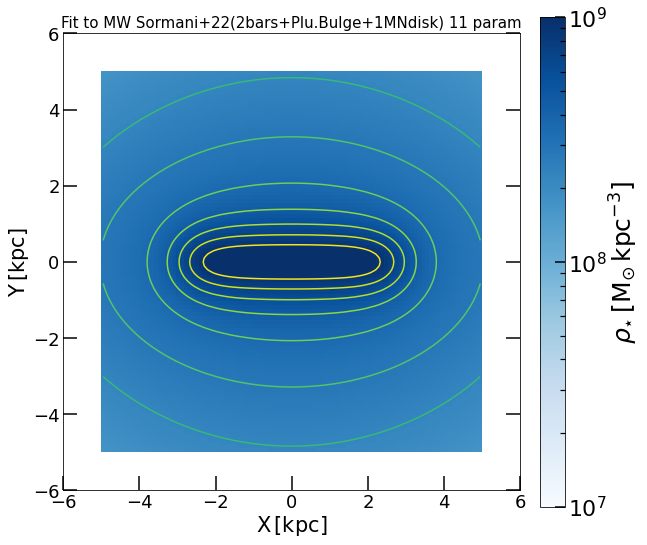

In [127]:
####################################################
### PLOTTING GENERIC fit to Sormani+22 with composite models that incude bars models from LONG & MURALI 1992 MODEL
xedges = xg_1D
yedges = yg_1D
Lim    = 6.
fig    = plt.figure(figsize=(9, 9))
# figtest.subplots_adjust(hspace=0.45, wspace=0.3)
ax   = fig.add_subplot(1, 1, 1)
vmax,vmin = 1E9,1E7
levelslog = np.logspace(np.log10(vmin),np.log10(vmax)+1,30)
# cmap = plt.get_cmap("inferno")
colormap = plt.get_cmap("Blues")

CS   = ax.imshow(rho_2D_fit2[:,:,izcenter],cmap =colormap,norm=colors.LogNorm(),interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmax=vmax,vmin=vmin)
CS2   = ax.contour(rho_2D_fit2[:,:,izcenter], levels=levelslog, color='k',norm=colors.LogNorm(),interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],vmax=vmax,vmin=vmin)
cbar  = fig.colorbar(CS, ax=ax,fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=22, direction='in',which='major', length=10, width=1.5) 
cbar.ax.tick_params(labelsize=22, direction='in',which='minor', length=5, width=1.2) 
cbar.set_label(r'$\rho_{\star}\,[{\rm M_{\odot}\,kpc^{-3}}]$', rotation=90,fontsize=25,labelpad=1)

ax.set_xlabel(r"${\rm X}\,[{\rm kpc}]$", fontsize=21, labelpad=1.9)
ax.set_ylabel(r"${\rm Y}\,[{\rm kpc}]$", fontsize=21, labelpad=1.9)
ax.set_title(f'Fit to MW Sormani+22(2bars+Plu.Bulge+1MNdisk) {len(parameter_medians)} param',fontsize=15)
ax.tick_params(axis='x', labelsize=18, length=14, width=1.5, which='major', direction='in')
ax.tick_params(axis='y', labelsize=18, length=14, width=1.5, which='major', direction='in',right='True')
ax.tick_params(axis='x', labelsize=15, length=9, width=1, which='minor', direction='in')
ax.tick_params(axis='y', labelsize=15, length=9, width=1, which='minor', direction='in',right='True')
# figtest.savefig(outputfile+"_PlotNbody.pdf", bbox_inches='tight') # for Zixuan v3
ax.set_xlim((-Lim,Lim))
ax.set_ylim((-Lim,Lim))